# HashComb testing notebook

In [62]:
import sys, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import math

sourceDir = Path.cwd() / "src"
if str(sourceDir) not in sys.path: 
    sys.path.insert(0, str(sourceDir))

from src.encoder import Encoder
from src.decoder import Decoder
from src.utils import Utils
from src.tree import Tree
from src.node import Node

### Tree definition

In [63]:
channels: int = 4
minVal: float = 0.0
maxVal: float = 15.0
configPath = "configuration.pkl"

encoder = Encoder(channels, maxVal, minVal, configPath)
decoder = Decoder(configPath)
print("Tree created with ", len(encoder.hashMap), " leaves")

Tree created with  16  leaves


*Cell with some useful plot functions*

In [71]:

t = Tree(channels, maxVal, minVal)

def collect_leaves(root: Node):
    leaves = []
    def rec(n: Node):
        if n is None: return
        if n.isLeaf():
            leaves.append(n)
        else:
            rec(n.left)
            rec(n.right)
    rec(root)

    leaves.sort(key=lambda n: n.min)
    return leaves

leaves = collect_leaves(t.root)
leaf_width = (maxVal - minVal) / (2**channels)


def plot_leaves_strip(leaves, inputs=None, title=None):
    if title is None:
        title = f"Leaf intervals — {len(leaves)} leaves"

    fig, ax = plt.subplots(figsize=(10, 2.8))
    y = 0.0

    for n in leaves:
        ax.plot([n.min, n.max], [y, y], linewidth=4)
        ax.plot([n.getCenter()], [y], marker="o")

    if inputs:
        for v in inputs:
            ax.plot([v], [y], marker="x", markersize=10)
            ax.annotate(f"{v:.3g}", xy=(v, y), xytext=(0,10), textcoords="offset points", ha="center")

    ax.set_yticks([])
    ax.set_xlabel("value")
    ax.set_title(title)
    ax.set_xlim(min(leaves[0].min, min(inputs) if inputs else leaves[0].min),
                max(leaves[-1].max, max(inputs) if inputs else leaves[-1].max))
    fig.tight_layout()
    plt.show()


def path_for_value(root: Node, v: float):
    path = []
    n = root
    while n is not None:
        path.append(n)
        if n.isLeaf():
            break
        c = n.getCenter()
        if v < c:
            n = n.left
        else:
            n = n.right
    return path

p = path_for_value(t.root, 12.34)


def nodes_by_level(root: Node):
    levels = []
    def rec(n: Node, depth: int):
        if n is None: return
        if depth == len(levels):
            levels.append([])
        levels[depth].append(n)
        if not n.isLeaf():
            rec(n.left, depth+1)
            rec(n.right, depth+1)
    rec(root, 0)
    return levels

def plot_tree_levels(root: Node, highlight_path=None, title=None):
    lvls = nodes_by_level(root)
    if title is None:
        title = f"Binary tree — depth={len(lvls)-1}"

    coords = {}
    for d, nodes in enumerate(lvls):
        width = len(nodes)
        xs = list(range(width))
        for i, n in enumerate(nodes):
            coords[n] = (i, -d)

    fig, ax = plt.subplots(figsize=(max(8, len(lvls[-1]) * 0.5), 1.8 + len(lvls)*0.8))
    for n, (x,y) in coords.items():
        if n.left:  ax.plot([x, coords[n.left][0]],  [y, coords[n.left][1]],  linewidth=1, alpha=0.5)
        if n.right: ax.plot([x, coords[n.right][0]], [y, coords[n.right][1]], linewidth=1, alpha=0.5)

    for n, (x,y) in coords.items():
        ax.plot(x, y, "o", ms=8, color="#666")
        ax.annotate(f"[{n.min:.3g}, {n.max:.3g}]", (x, y), textcoords="offset points", xytext=(0,10), ha="center", fontsize=8)

    if highlight_path:
        xs = [coords[n][0] for n in highlight_path]
        ys = [coords[n][1] for n in highlight_path]
        ax.plot(xs, ys, "-o", color="C3", linewidth=2.5, ms=10)
        ax.plot(xs[-1], ys[-1], "o", ms=14, mfc="none", mec="C3", mew=2.5)

    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(-1, len(lvls[-1]))
    ax.invert_yaxis() 
    fig.tight_layout()
    plt.show()

def visualize_config_pkl(configPath: str, show_table: bool = True):
    hmap: dict[str, Node] = Utils.readHashTable2File(configPath)
    print(f"Caricato {configPath}, numero foglie: {len(hmap)}")

    rows = []
    for h, n in hmap.items():
        rows.append({
            "hash": h,
            "min": n.min,
            "center": n.getCenter(),
            "max": n.max,
            "width": n.max - n.min
        })
    df = pd.DataFrame(rows).sort_values("min").reset_index(drop=True)

    if show_table:
        display(df.head(20)) 

    fig, ax = plt.subplots(figsize=(10, 2.8))
    y = 0.0
    for _, r in df.iterrows():
        ax.plot([r["min"], r["max"]], [y, y], linewidth=4)
        ax.plot([r["center"]], [y], marker="o")
    ax.set_yticks([])
    ax.set_xlabel("value")
    ax.set_title(f"Leaf intervals — {len(df)} leaves")
    plt.show()

    plt.figure(figsize=(6,3))
    plt.hist(df["center"], bins=len(df), edgecolor="black")
    plt.title("Centers histogram")
    plt.xlabel("center")
    plt.ylabel("count")
    plt.show()

    return df 

print("plot function created correctly")

plot function created correctly


## configuration.pkl *file reader*

Caricato configuration.pkl, numero foglie: 16


,hash,min,center,max,width
0,191192860,0.0000,0.46875,0.9375,0.9375
1,83723393,0.9375,1.40625,1.8750,0.9375
2,69714131,1.8750,2.34375,2.8125,0.9375
3,54779781,2.8125,3.28125,3.7500,0.9375
4,97437539,3.7500,4.21875,4.6875,0.9375
5,78225310,4.6875,5.15625,5.6250,0.9375
6,120916776,5.6250,6.09375,6.5625,0.9375
7,166845026,6.5625,7.03125,7.5000,0.9375
8,228294355,7.5000,7.96875,8.4375,0.9375
9,186127803,8.4375,8.90625,9.3750,0.9375


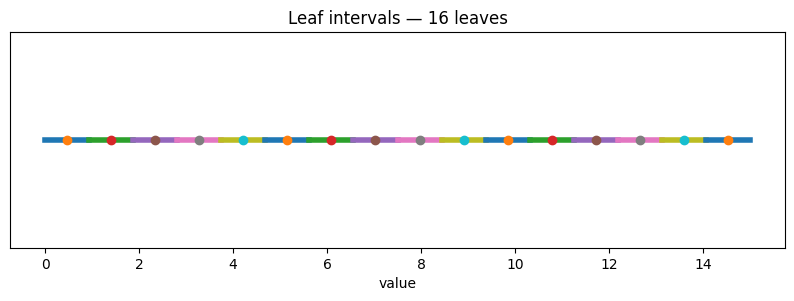

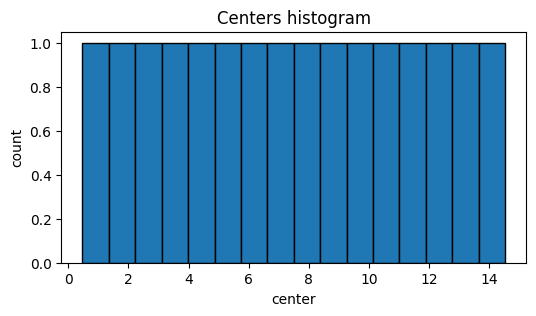

In [65]:
df = visualize_config_pkl("configuration.pkl")

## Define some values as **TEST**

In [66]:
values = [0.5, 2.3, 5.0, 7.25, 12.34, 15.0]
value = values[4]

### SINGLE VALUE encode-decode **test**

In [67]:

print("value: ", value)
hashed = encoder.encode(value)
print("hashed value: ", hashed)
decoded = decoder.decode(hashed)
print("decoded value: ", decoded)


value:  12.34
hashed value:  240568042
decoded value:  12.65625


### LIST VALUES encode-decode **test**

In [68]:
rows =[]

for singlevalue in values:
    hashed = encoder.encode(singlevalue)
    decoded = decoder.decode(hashed)
    rows.append((singlevalue, hashed, decoded))

print(f"{'Value':>8} | {'Hash':>10} | {'Decoded':>10}")
print("-" * 35)
for v, h, d in rows:
    print(f"{v:8.3f} | {h:>10} | {d:10.3f}")

   Value |       Hash |    Decoded
-----------------------------------
   0.500 |  191192860 |      0.469
   2.300 |   69714131 |      2.344
   5.000 |   78225310 |      5.156
   7.250 |  166845026 |      7.031
  12.340 |  240568042 |     12.656
  15.000 |   36017770 |     14.531


### Tree test *viewer*

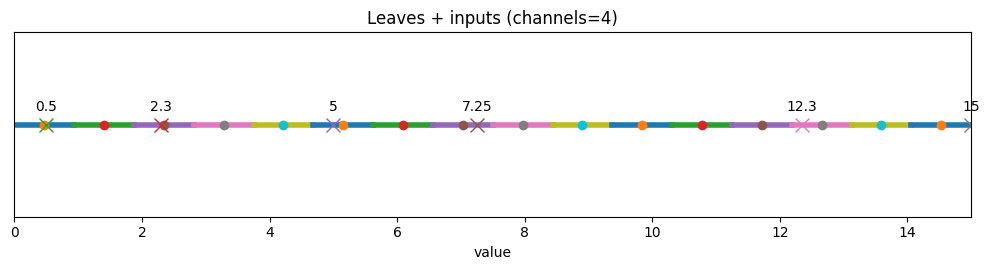

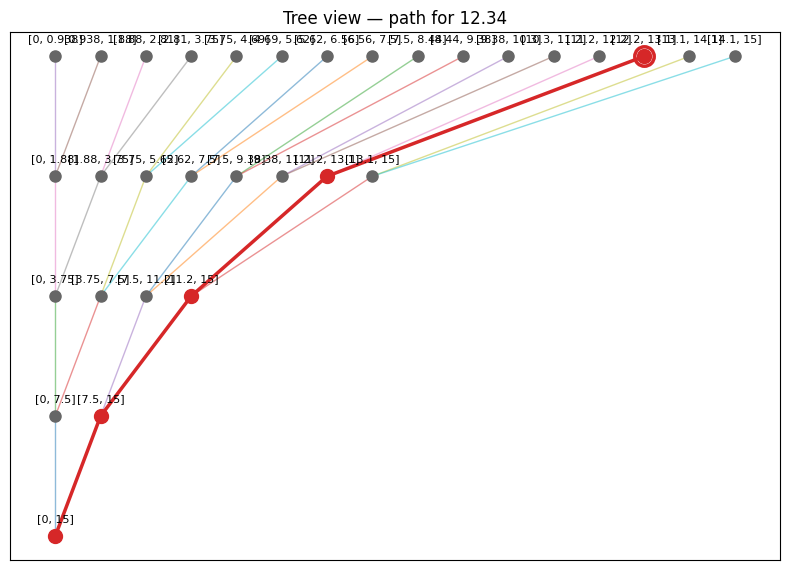

In [69]:
plot_leaves_strip(leaves, inputs=values, title=f"Leaves + inputs (channels={channels})")

plot_tree_levels(t.root, highlight_path=path_for_value(t.root, value),
                 title=f"Tree view — path for {value}")